In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the gradient data from CSV files
# Adjust filenames as needed
attention_filenames = [f'/home/jan.malasnicki/Downloads/scaled_gradient_norm_encoder_blocks_block_{i}_block_residual_attention_layer_attention_output_projection_weight.csv' for i in range(8)]
expert_filenames = [f'/home/jan.malasnicki/Downloads/scaled_gradient_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_expert_inner_function_lin1_weight.csv' for i in range(8)]
gating_filenames = [f'/home/jan.malasnicki/Downloads/scaled_gradient_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_expert_inner_function_gate_weight.csv' for i in range(8)]


# Load CSVs and assign column names
column_names = ['Step', 'Placeholder', 'Gradient Norm']
attention_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in attention_filenames]
expert_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in expert_filenames]
gating_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in gating_filenames]
multiplier = 0.05
for df in attention_dfs:
    df['Gradient Norm'] *= multiplier


In [2]:
# Define a function to plot a single subplot
def plot_gradient_norms(ax, df, title):
    steps = df['Step'].values
    grad_norms = df['Gradient Norm'].values
    ax.plot(steps, grad_norms, label='Gradient Norm')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Gradient Norm')
    ax.set_title(title)
    ax.grid(True)


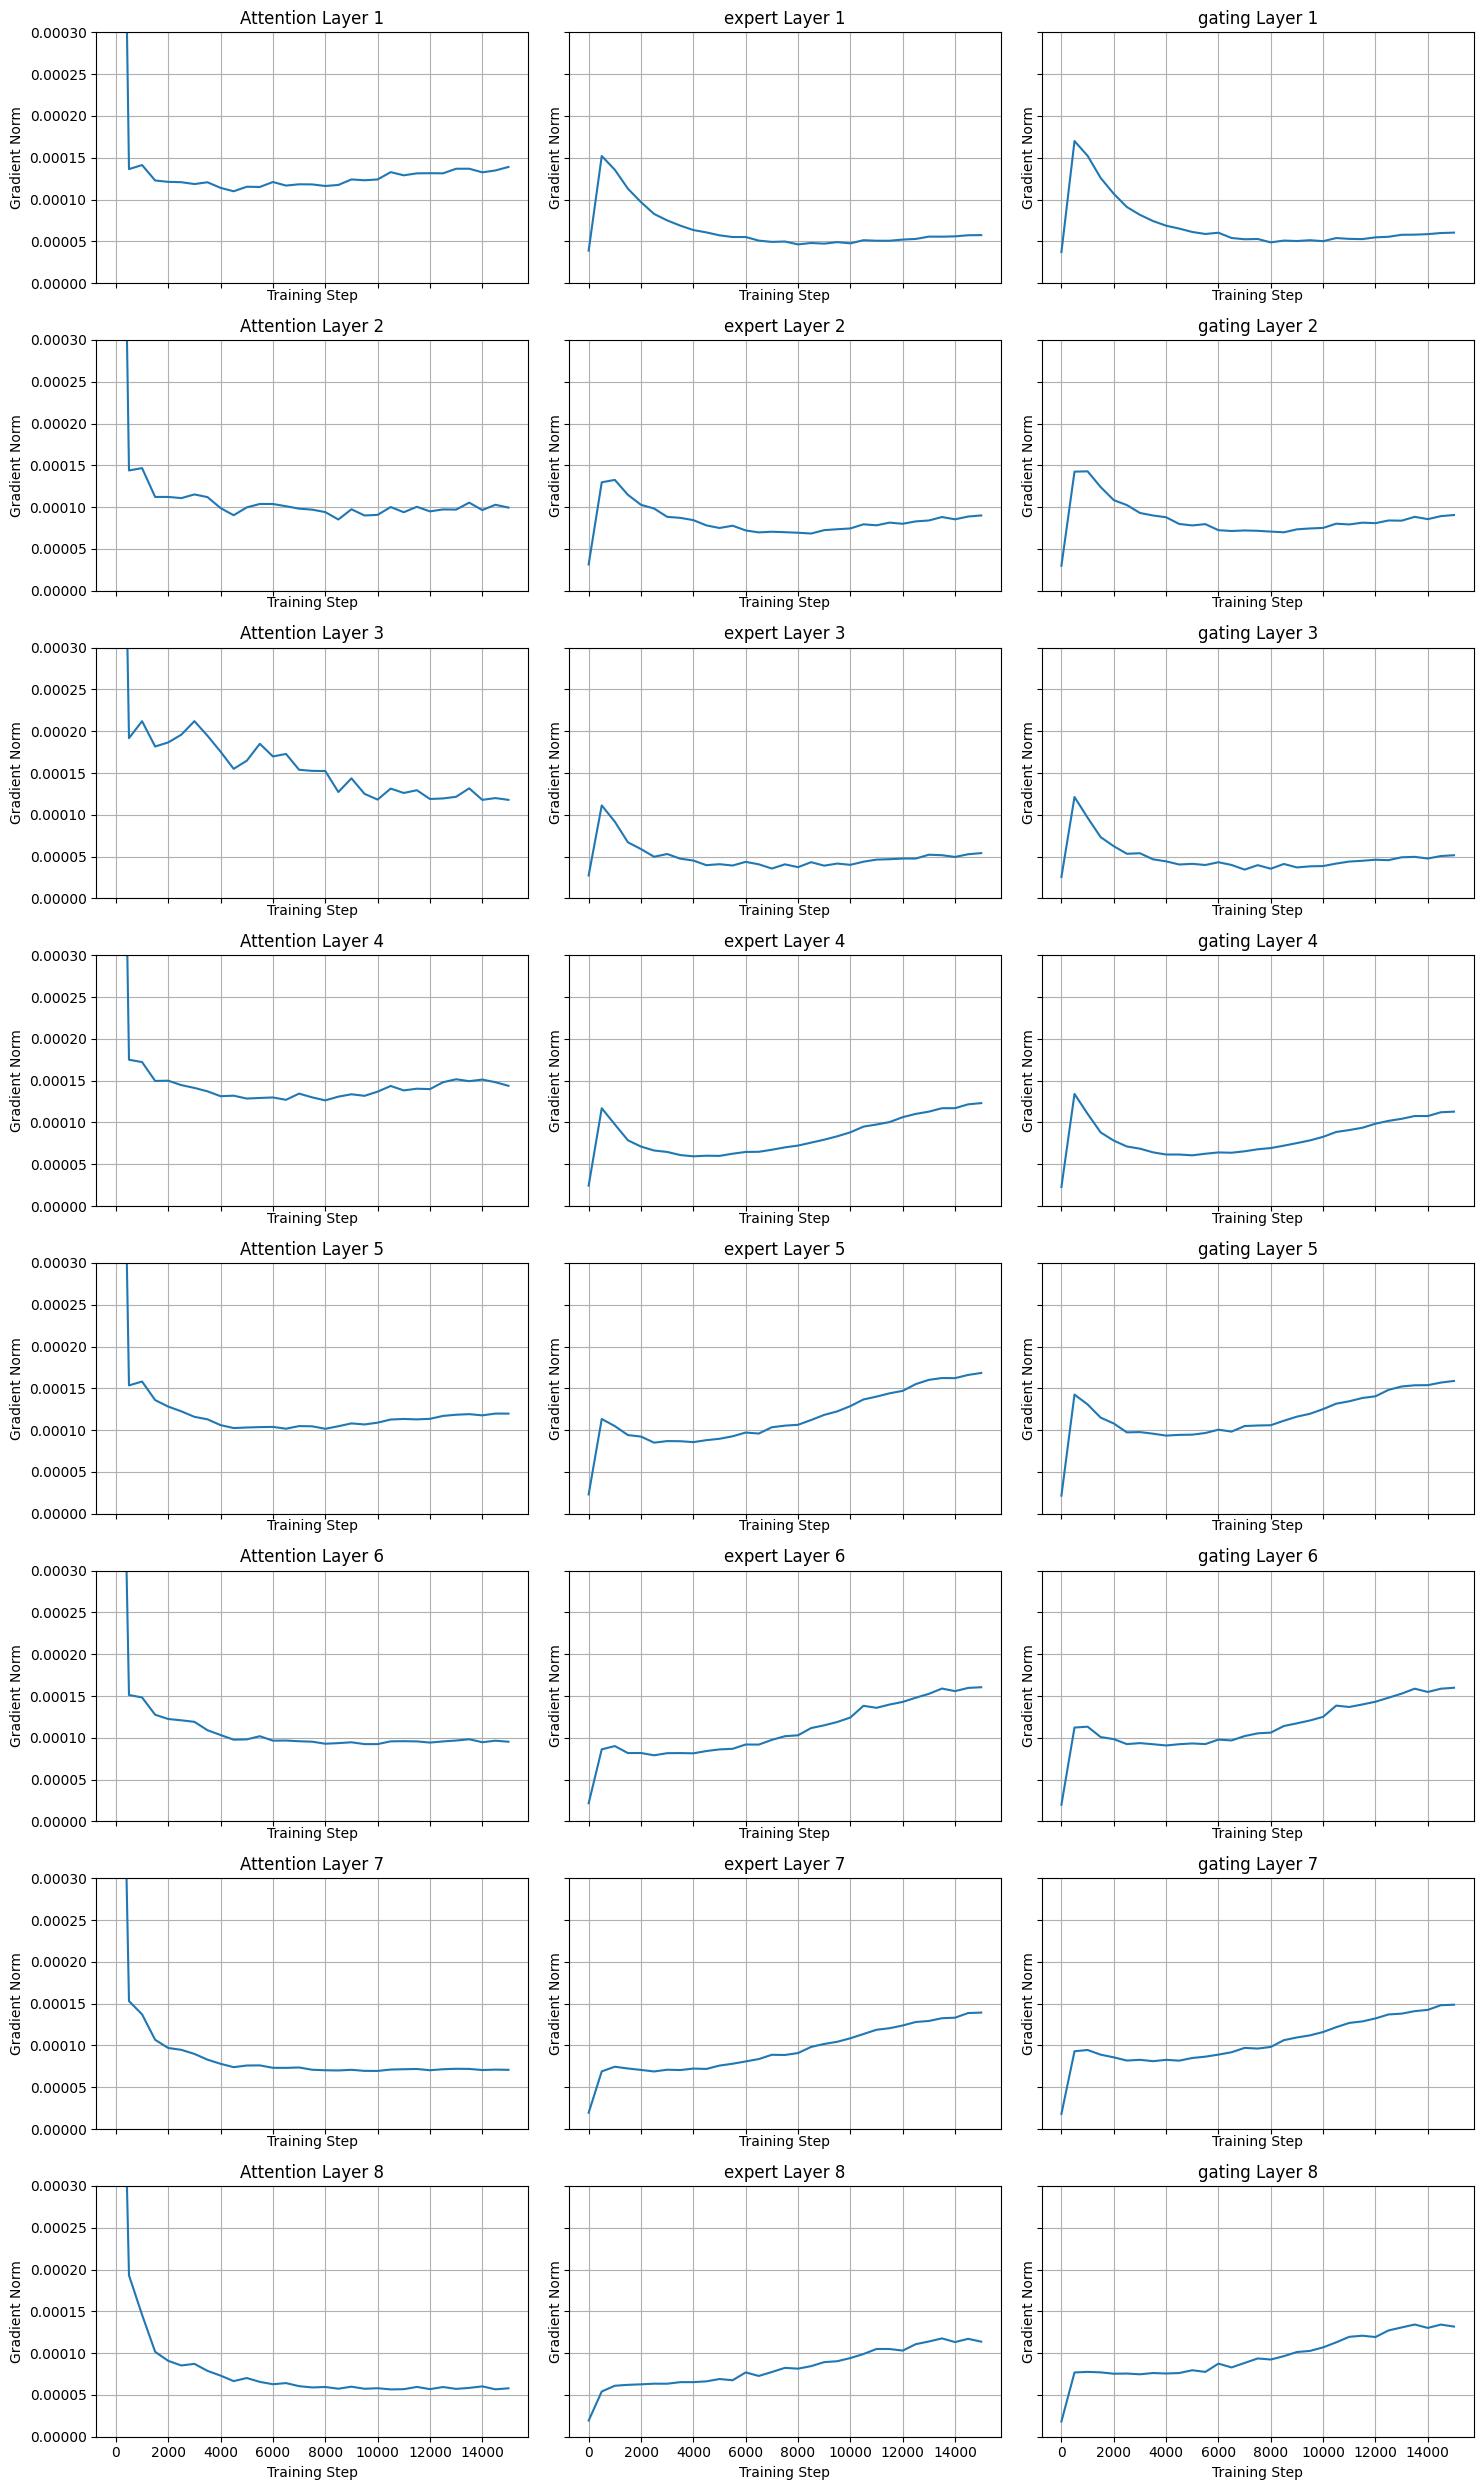

In [3]:
# Create a figure with 16 subplots (8 rows and 2 columns)
fig, axes = plt.subplots(8, 3, figsize=(15, 25), sharex=True, sharey=True)

# Plot Attention gradients
for i, df in enumerate(attention_dfs):
    plot_gradient_norms(axes[i, 0], df, f'Attention Layer {i+1}')

# Plot expert gradients
for i, df in enumerate(expert_dfs):
    plot_gradient_norms(axes[i, 1], df, f'expert Layer {i+1}')

# Plot MLP gradients
for i, df in enumerate(gating_dfs):
    plot_gradient_norms(axes[i, 2], df, f'gating Layer {i+1}')

# Adjust layout
plt.ylim(0, 0.0003)
plt.tight_layout()
plt.savefig('grad_norms.png')
plt.show()